# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [37]:
# Astonishingly there seems to be no clean way to set up the Python path automatically for a script that does not
# reside in the root folder. This will need to be added to all notebooks unless a better solution comes along.
import os, sys
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import scipy

from utils import load_yaml

sns.set_theme()

# Utility Functions

In [16]:
from tqdm import tqdm


def load_dataframes(eval_folder, verbose=False):
    """
    Given a folder with a number of pickled dataframes, load and return all of them.
    """
    if verbose:
        print(f"Loading from: {eval_folder.name}")
    all_frames = [pd.read_pickle(f) for f in eval_folder.glob("*.pkl")]
    if verbose:
        print(f"Loaded {len(all_frames)} dataframes for {eval_folder.name}.")
    return all_frames

    
def load_eval_data(eval_folder, verbose=False):
    """
    Given a folder with a number of pickled dataframes, load all results into a single dataframe.
    """
    all_frames = load_dataframes(eval_folder, verbose)
    if all_frames:
        all_data = pd.concat(all_frames)
    else:
        all_data = pd.DataFrame()
    if verbose:
        print(f"Loaded total {len(all_frames)} dataframes for total size = {all_data.shape}")
    return all_data


def load_eval_data_with_model_name(model_name, eval_folder, verbose=False):
    """
    Load dataframes in the given folder, and replace the "model" column with the given `model_name`.
    """
    all_frames = load_dataframes(eval_folder, verbose)

    # Replace model path with model shortname.
    # TODO: Need to find a more efficient way to do this.
    loop = tqdm(all_frames) if verbose else all_frames
    for df in loop:
        # Here's the original way to do it, and it's way too slow.
        #orig = df.index.get_level_values("model")[0]  # Get original name.
        #df.rename(index={orig: model_name}, level="model", inplace=True)  # Replace with short name.
        newdex = df.index.to_frame(index=False)
        newdex["model"] = [model_name] * len(newdex["model"])  # Replace entire model column w/ short name.
        newdex = pd.MultiIndex.from_frame(newdex, names=df.index.names)
        df.set_index(newdex, inplace=True)

    if all_frames:
        all_data = pd.concat(all_frames)
    else:
        all_data = pd.DataFrame()
    if verbose:
        print(f"Loaded total {len(all_frames)} dataframes for total size = {all_data.shape}")
    return all_data


def ensure_unique(df, index_columns):
    """
    Ensures that the given columns only contain one value; otherwise raises an exception.

    This is a safety check to ensure we don't erroneously aggregate across runs that aren't comparable. For example,
    if our dataframe could have results from more than one model, we don't usually want to aggregate over all models,
    so we would pass in the "model" column here.
    """
    if isinstance(index_columns, str):
        index_columns = [index_columns]
    for col in index_columns:
        unique = df.index.get_level_values(col).unique()
        if len(unique) > 1:
            raise RuntimeError(f"Refusing to aggregate across runs with different '{col}': {unique.to_numpy()}.")

# Scan for Trained Models

Given a project folder, we will scan for all the training jobs in that folder. Each training job has produced a number of model checkpoints, and we will find all the ones which have already been evaluated.

This assumes that project folders have the structure: `<project>/<training-job>/train-config.yml`.

In [4]:
# Original Omniglot results.
#PROJECT_ROOT = Path("/gpfs2/scratch/ntraft/Development/higherANML/experiments/flat-vs-nested")
# Original ImageNet results.
PROJECT_ROOT = Path("../experiments/inet-flat-vs-nested").resolve()

In [5]:
# Create a map from name -> training config.
train_config_files = {}
for f in PROJECT_ROOT.iterdir():
    if f.is_dir():
        cfg_path = f / "train-config.yml"
        if cfg_path.is_file():
            train_config_files[f.stem] = cfg_path

# Let's sort the dict by model name, for convenience.
train_config_files = dict(sorted(train_config_files.items()))

In [6]:
# Load the YAML files.
train_configs = {k: load_yaml(v) for k, v in train_config_files.items()}
print(f"Found {len(train_configs)} training jobs.")

Found 57 training jobs.


# Choose the "Best" Checkpoint

Each model may have a number of evaluated checkpoints. For each training job, we'll choose just one checkpoint to use for evaluation. We'll do so by choosing the checkpoint with the best "zero-shot" or "no-SGD" performance.

Note that there are a bunch of assumptions in the code below about what results we actually have:
1. All models have no-SGD results, otherwise they're ignored.
1. Each checkpoint only has one no-SGD evaluation.
1. Each no-SGD folder only contains one set of trials.
1. Some assumptions on the naming of these folders.
If we ever decide to run more different no-SGD evals then these assumptions need to be revisited.

In [7]:
def best_checkpoint(eval_folders):
    if len(eval_folders) == 1:
        return eval_folders[0]
    perfs = np.array([final_performance(f) for f in eval_folders])
    if np.all(np.isnan(perfs)):
        return None
    return eval_folders[np.nanargmax(perfs)]


def final_performance(eval_folder):
    df = load_eval_data(eval_folder)
    if df.empty:
        return np.nan
    # WARNING: Assumes all datapoints in this folder correspond to a single evaluation (we don't need to filter down
    # to the evaluation we actually want).
    return df["test_acc"].mean()


def get_checkpoint_number(eval_folder):
    # WARNING: This CLOSELY depends on the naming of the eval folders, and I'm not sure it'll always work.
    return int(eval_folder.stem.split("-")[2])


best_checkpoints = {}
for name, f in train_config_files.items():
    pdir = f.parent
    # First check for folders just ending with "no-sgd".
    no_sgd_evals = list(pdir.glob("eval-*-no-sgd"))
    if not no_sgd_evals:
        # If we don't find "no-sgd", there might be multiple and we should find the "large" one.
        no_sgd_evals = list(pdir.glob("eval-*-no-sgd-*-lg"))
        if not no_sgd_evals:
            print(f"WARNING: Could not find no-SGD results for {name}.")
            continue
            # If you want to debug this condition, uncomment the following line:
            # print(f"Files: {[f.name for f in pdir.iterdir()]}")

    # Now we have a list of evals; assuming one per checkpoint.
    best = best_checkpoint(no_sgd_evals)
    if best is not None:
        best_checkpoints[name] = get_checkpoint_number(best)
    else:
        print(f"WARNING: All no-SGD results for {name} are empty.")

In [8]:
# Create a map of name -> list of eval folders for the best checkpoint.
# WARNING: Closely depends on the naming of the eval folders, and may not stand the test of time.
all_eval_folders = {name: list((PROJECT_ROOT / name).glob(f"eval-*-{ckpt}-*"))
                    for name, ckpt in best_checkpoints.items()}
# Sanity check.
missing_results = []
invalid_results = []
for name, l in all_eval_folders.items():
    if len(l) <= 1:
        # The only result is the no-sgd result, or even that was not found for some reason.
        missing_results.append(name)
    for f in l:
        if not f.is_dir():
            # Not a valid results dir.
            invalid_results.append(f)

if missing_results:
    for name in missing_results:
        print(f"WARNING: Unable to find any results for {name}, checkpoint #{best_checkpoints[name]}.")
if invalid_results:
    print(f"ERROR: The following should be valid directories but are not:\n{[f.name for f in invalid_results]}")

# Load Evaluation Data

Now, for each model, we have all the evals performed on the best model checkpoint. We'd like to load all these evals into a single dataframe for further processing.

For brevity, we want each model to have a "short name" that can be used in plots and legends. This will replace the original `model` column, which is a filename. We'll name them using the training job name and the model checkpoint.

In [38]:
%%time

import re
from collections import defaultdict

# Organize dataframes by evaluation type.
all_frames = defaultdict(list)
for name, eval_folders in tqdm(all_eval_folders.items()):
    #print(f"Loading {len(eval_folders)} evaluations for {name}...")
    for folder in eval_folders:
        eval_type = re.match(r".*?-[0-9]+-(.*)$", folder.name).group(1)
        eval_data = load_eval_data_with_model_name(f"{name}-{best_checkpoints[name]}", folder)
        all_frames[eval_type].append(eval_data)

print("Evaluation Results:")
for eval_type in all_frames:
    before_concat = all_frames[eval_type]
    all_frames[eval_type] = pd.concat(before_concat)
    print(f"  {eval_type}: {len(before_concat)} models -> {all_frames[eval_type].shape} dataframe")

100%|██████████| 44/44 [02:33<00:00,  3.48s/it]


Evaluation Results:
  unfrozen: 39 models -> (5204000, 2) dataframe
  olft: 39 models -> (5420000, 2) dataframe
  iid-olft: 39 models -> (61710, 4) dataframe
  no-sgd: 44 models -> (390, 4) dataframe
  iid-lstsq-unfrozen: 39 models -> (62950, 4) dataframe
  iid-unfrozen: 39 models -> (65470, 4) dataframe
  lstsq-unfrozen: 39 models -> (4612000, 2) dataframe
CPU times: user 2min 26s, sys: 11.2 s, total: 2min 37s
Wall time: 2min 51s


In [39]:
# Clear up what memory we can, in case we are loading some large frames...
# In my experiment with 144M rows, this took memory from 7.2 GB --> 6.2 GB; not that much, unfortunately.
import gc
gc.collect()

0

# Performance Curves

In [44]:
all_frames["olft"]

train_acc  \
model                     dataset      train_examples test_examples eval_method reinit_method reinit_params     opt_params classes lr    trial epoch classes_trained class_id              
absurd-wave-14899-2000    miniimagenet 30             200           sequential  kaiming       classifier.linear classifier 20      0.010 0     0     1               0               1.0   
                                                                                                                                                                     1               0.0   
                                                                                                                                                                     2               0.0   
                                                                                                                                                                     3               0.0   
                                                                                                                                                                     4               0.0   
...                                                                                                                                                                                  ...   
youthful-wood-32388-10000 miniimagenet 20             200           sequential  kaiming       classifier.linear classifier 20      0.055 9     19    20              15              0.0   
                                                                                                                                                                     16              0.0   
                                                                                                                                                                     17              0.0   
                                                                                                                                                                     18              0.0   
                                                                                                                                                                     19              1.0   

                                                                                                                                                                               test_acc  
model                     dataset      train_examples test_examples eval_method reinit_method reinit_params     opt_params classes lr    trial epoch classes_trained class_id            
absurd-wave-14899-2000    miniimagenet 30             200           sequential  kaiming       classifier.linear classifier 20      0.010 0     0     1               0              1.0  
                                                                                                                                                                     1              0.0  
                                                                                                                                                                     2              0.0  
                                                                                                                                                                     3              0.0  
                                                                                                                                                                     4              0.0  
...                                                                                                                                                                                 ...  
youthful-wood-32388-10000 miniimagenet 20             200           sequential  kaiming       classifier.linear classifier 20      0.055 9     19    20              15             0.0  
                                                        

# HI LAPO!

Here is where I've left off with the notebook. Everything below is copied from a previous notebook (`anml-meta-test-comparison.ipynb`). The new notebook scans a single project folder and tries to pull all results into a single dataframe for processing.

Now we're at the part where we need to actually do the processing and compile the final statistics we want!

See above to see the format of the dataframe we have so far. Kind of a crazy design with the huge multi-index, but it has its advantages.
- One thing we want to do is produce comparisons across different models on the same eval mode. To do this we might do something like:
  - Filter by the eval mode we want (eval_method, reinit_method, # train examples, etc.).
  - Then group by model name.
  - Then take mean and std to get stats for each model.
- To see some examples of how to process this multi-index dataframe, see the examples below, but they're a bit outdated (column names and contents have changed).

# Sequential Fine-Tuning Evaluation

For the subsequent plots, we only want to evaluate on classes seen so far, so let's insert NaN values in places where the class had not yet been trained on.

In [45]:
# Change this line to not copy in order to save memory; but this will lose data.
eval_type = "olft"
classes_seen_perf = all_frames[eval_type]#.copy()

# Nix all rows where classes_trained <= class_id.
unseen_rows = (classes_seen_perf.index.get_level_values("classes_trained") <= 
               classes_seen_perf.index.get_level_values("class_id"))
classes_seen_perf[unseen_rows] = np.nan

For each training configuration, get a series of average performance per classes trained. First, we want to average over all classes to get overall performance numbers.

In [51]:
%%time

# Average over all classes to get overall performance numbers, by grouping by columns other than class.
groupby_labels = set(classes_seen_perf.index.names)
groupby_labels.remove("class_id")
over_all_classes = classes_seen_perf.groupby(list(groupby_labels)).mean()

CPU times: user 3.44 s, sys: 1.68 s, total: 5.12 s
Wall time: 10.8 s


In [52]:
# Optional deletion of intermediate data to save more memory.
del classes_seen_perf
_ = gc.collect()

Now, plot a graph with the best learning rate per data point.

In [53]:
over_all_classes

train_acc  \
test_examples dataset      reinit_method classes_trained reinit_params     epoch train_examples lr       classes trial model                      eval_method opt_params              
200           miniimagenet kaiming       1               classifier.linear 0     10             0.000005 20      0     absurd-wave-14899-2000     sequential  classifier       0.00   
                                                                                                                       astral-shadow-32394-25000  sequential  classifier       0.00   
                                                                                                                       atomic-pyramid-32397-9000  sequential  classifier       0.00   
                                                                                                                       copper-water-14900-2000    sequential  classifier       0.00   
                                                                                                                       curious-brook-15280-10000  sequential  classifier       0.00   
...                                                                                                                                                                             ...   
                                         20              classifier.linear 19    30             0.100000 20      9     tough-resonance-15275-5000 sequential  classifier       0.05   
                                                                                                                       true-pine-14-5000          sequential  classifier       0.05   
                                                                                                                       vibrant-oath-32402-9000    sequential  classifier       0.05   
                                                                                                                       visionary-sea-32400-9000   sequential  classifier       0.05   
                                                                                                                       youthful-wood-32388-10000  sequential  classifier       0.05   

                                                                                                                                                                          test_acc  
test_examples dataset      reinit_method classes_trained reinit_params     epoch train_examples lr       classes trial model                      eval_method opt_params            
200           miniimagenet kaiming       1               classifier.linear 0     10             0.000005 20      0     absurd-wave-14899-2000     sequential  classifier      0.00  
                                                                                                                       astral-shadow-32394-25000  sequential  classifier      0.02  
                                                                                                                       atomic-pyramid-32397-9000  sequential  classifier      0.00  
                                                                                                                       copper-water-14900-2000    sequential  classifier      0.00  
                                                                                                                       curious-brook-15280-10000  sequential  classifier      0.00  
...                                                                                                                                                                            ...  
                                         20              classifier.linear 19    30             0.100000 20      9     tough-resonance-15275-5000 sequential  classifier      0.05  
                                                                                                                       true-pine-14-5000          sequential  cla

In [63]:
# Filter the data to just 30 examples per class.
rows = over_all_classes.index.get_level_values("train_examples") == 30
desired_rows = over_all_classes.loc[rows]

# Group the potential data for each data point separately. So each group contains all trials and all learning rates for
# a single test method (so all index columns except for those).
groupby_labels = set(desired_rows.index.names)
groupby_labels.remove("lr")
groupby_labels.remove("trial")
groupby_labels = list(groupby_labels)
seq_eval_groups = desired_rows.groupby(groupby_labels)

def select_best_lr(train_group):
    """
    Reduces a dataframe with many learning rates to one with one learning rate, retaining all trials for the selected
    learning rate. Learning rate is selected by highest mean test accuracy.
    """
    lr_perf = train_group.groupby("lr").mean()
    # Tells us which LR is the best.
    best_lr = lr_perf.iloc[lr_perf.loc[:, "test_acc"].argmax()].name
    # Grabs all trials corresponding to the best LR.
    rows = train_group.index.get_level_values("lr") == best_lr
    # We must remove all the columns that are already specified by the group, because otherwise .apply() is not smart
    # enough to remove them and they will be duplicated.
    return train_group.loc[rows].reset_index(level=groupby_labels, drop=True)

# For each point on the x-axis, select the learning rate with the best average performance over trials.
# Need to use .apply() here because our function needs all columns at once.
best_trials_per_point = seq_eval_groups.apply(select_best_lr)

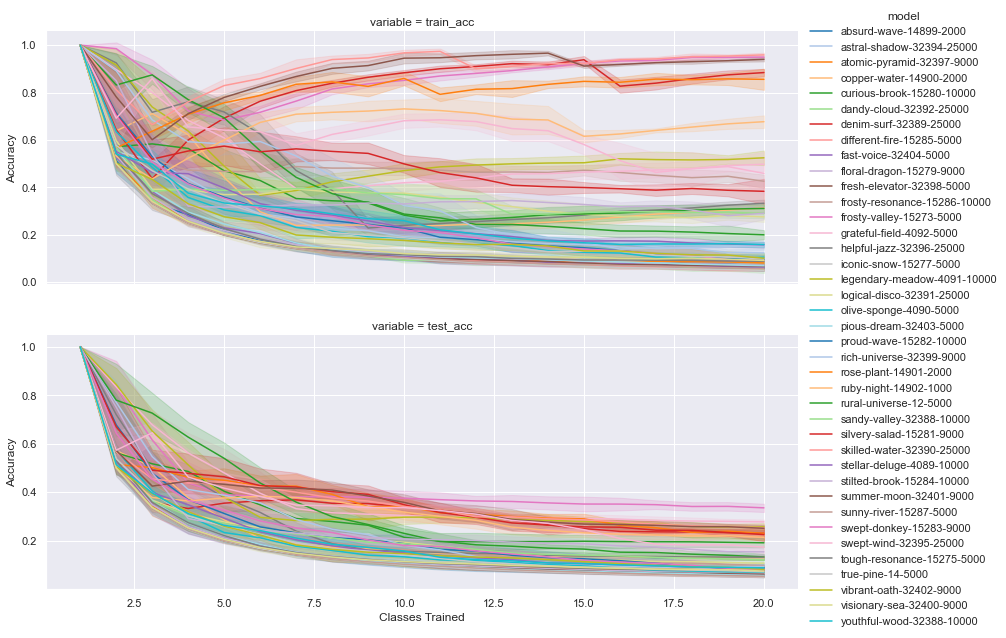

In [70]:
import warnings

# Plot the results from the previous cell.
def plot_traj_per_lr(df, vars_to_plot, **kwargs):
    df = df.melt(value_vars=vars_to_plot, ignore_index=False)
    # We want to make sure we are not accidentally aggregating across runs with different configs.
    ensure_unique(df, ["dataset", "test_examples", "classes", "eval_method", "opt_params", "reinit_method"])
    # Only add more levels of nesting if needed.
    hue = None
    if df.index.get_level_values("model").nunique() > 1:
        hue = "model"
    style = None
    if df.index.get_level_values("train_examples").nunique() > 1:
        style = "train_examples"

    # Temporarily suppress this annoying and unnecessary warning coming from Seaborn.
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*not compatible with tight_layout.*")
        fg = sns.relplot(
            data=df,
            x="classes_trained",
            y="value",
            row="variable",
            hue=hue,
            style=style,
            palette="tab20",
            kind="line",
            ci="sd",
            height=5,
            aspect=2.5,
            facet_kws=dict(sharey=False, gridspec_kws=dict(top=0.90)),
            **kwargs
        )
    # Adjust labels.
    fg.set_axis_labels("Classes Trained", "Accuracy")

# Plot results
fg = plot_traj_per_lr(best_trials_per_point, ["train_acc", "test_acc"])

In [65]:
# Print final accuracy per model, when fine-tuned on 30 examples.
models = best_trials_per_point.index.get_level_values("model")
classes_trained = best_trials_per_point.index.get_level_values("classes_trained")
train_examples = best_trials_per_point.index.get_level_values("train_examples")
num_classes = classes_trained.max()
print(f"Final accuracy on {num_classes} classes:")
for m in models.unique():
    rows = (classes_trained == num_classes) & (models == m) & (train_examples == 30)
    final_acc = best_trials_per_point.loc[rows, "test_acc"]
    print(f"{m: >30} | {final_acc.mean():>5.1%} (std: {final_acc.std():.1%})")

Final accuracy on 20 classes:
        absurd-wave-14899-2000 |  5.5% (std: 0.5%)
     astral-shadow-32394-25000 |  7.9% (std: 0.8%)
     atomic-pyramid-32397-9000 |  7.6% (std: 1.7%)
       copper-water-14900-2000 | 12.9% (std: 0.9%)
     curious-brook-15280-10000 | 13.3% (std: 1.3%)
       dandy-cloud-32392-25000 |  5.5% (std: 0.6%)
        denim-surf-32389-25000 | 23.1% (std: 1.3%)
     different-fire-15285-5000 |  5.0% (std: 0.1%)
         fast-voice-32404-5000 |  5.9% (std: 0.5%)
      floral-dragon-15279-9000 |  6.2% (std: 0.4%)
     fresh-elevator-32398-5000 |  6.1% (std: 0.9%)
  frosty-resonance-15286-10000 |  9.7% (std: 1.0%)
      frosty-valley-15273-5000 | 33.5% (std: 1.7%)
      grateful-field-4092-5000 | 27.7% (std: 1.0%)
      helpful-jazz-32396-25000 | 13.2% (std: 1.2%)
        iconic-snow-15277-5000 |  5.0% (std: 0.0%)
   legendary-meadow-4091-10000 | 25.7% (std: 1.5%)
     logical-disco-32391-25000 | 10.7% (std: 0.5%)
        olive-sponge-4090-5000 |  7.0% (std: 0.7%)
 

# Sensitivity to Learning Rate

In [32]:
# Combine train/test columns into a single column, for the convenience of using `sns.relplot()`.
overall_accuracy = over_all_classes.rename(columns={"train_acc": "train", "test_acc": "test"})
overall_accuracy = overall_accuracy.melt(var_name="split", value_name="accuracy", ignore_index=False)

CPU times: user 2.2 s, sys: 59.4 ms, total: 2.26 s
Wall time: 3.35 s


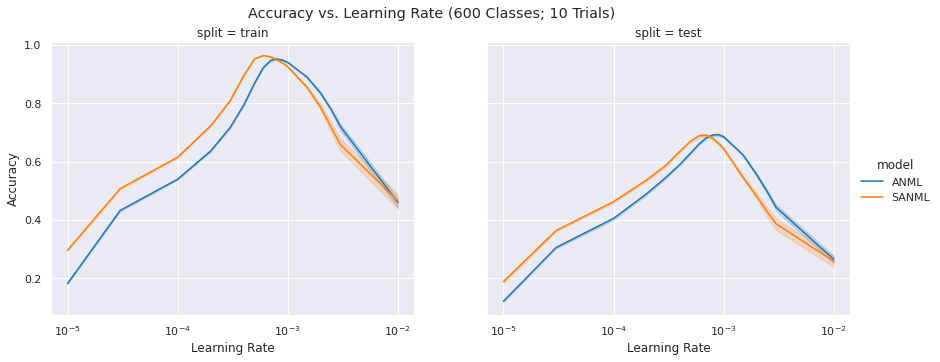

In [52]:
%%time

import warnings
from numbers import Number

# We want to plot the result of learning this number of classes across different choices of learning rate.
def plot_perf_vs_learning_rate(df, num_classes_learned, lr_range=None):

    # Filter down to just the slice that has learned this many classes.
    if isinstance(num_classes_learned, Number):
        # Convert to list of numbers first.
        num_classes_learned = [num_classes_learned]
    classes_trained = df.index.get_level_values("classes_trained")
    df = df.loc[classes_trained.map(lambda x: x in num_classes_learned), :]
    
    # Filter to only the desired learning rates.
    if lr_range:
        assert len(lr_range) == 2
        lrs = df.index.get_level_values("lr")
        rows = (lrs >= lr_range[0]) & (lrs <= lr_range[1])
        df = df.loc[rows, :]        
    
    # We want to make sure we are not accidentally aggregating across runs with different configs.
    ensure_unique(df, ["dataset", "num_test_examples"])
    # Only add more levels of nesting if needed.
    hue = None
    if df.index.get_level_values("model").nunique() > 1:
        hue = "model"
    style = None
    nte = df.index.get_level_values("num_train_examples")
    ct = df.index.get_level_values("classes_trained")
    if nte.nunique() > 1 and ct.nunique() > 1:
        # We can't have both of these at once.
        raise RuntimeError("Cannot show multiple values of both 'num_train_examples' and 'classes_trained'.")
    elif ct.nunique() > 1:
        style = "classes_trained"
    elif nte.nunique() > 1:
        style = "num_train_examples"

    # Temporarily suppress this annoying and unnecessary warning coming from Seaborn.
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*not compatible with tight_layout.*")
        fg = sns.relplot(
            data=df,
            x="lr",
            y="accuracy",
            col="split",
            hue=hue,
            style=style,
            palette="tab10",
            kind="line",
            #ci="sd",  # Remove this to plot 95% CI instead. It will take a long time.
            aspect=1.3,
            facet_kws=dict(gridspec_kws=dict(top=0.88))
        )
    # Adjust labels.
    ntrials = df.index.get_level_values("trial").nunique()
    fg.set(xscale="log")
    cls_text = ""
    if len(num_classes_learned) == 1:
        cls_text = f"{num_classes_learned[0]} Classes; "
    fg.figure.suptitle(f"Accuracy vs. Learning Rate ({cls_text}{ntrials} Trials)")
    fg.set_axis_labels("Learning Rate", "Accuracy")


# Determine which point(s) on the learning trajectories to plot.
num_classes = [600]
# Now do the plotting.
plot_perf_vs_learning_rate(overall_accuracy, num_classes)#, lr_range=(float("-inf"), 0.03))

# Scratch Space

In [19]:
# Summarizing the final performance across all runs in a single dataframe.
one_file = next(Path(".").glob("*.pkl"))
print(f"Loading runs from {one_file}")
df = pd.read_pickle(one_file)
print(f"Dataframe shape: {df.shape}")

# Average over all classes to get overall performance numbers, by grouping by columns other than class.
non_class_labels = list(filter(lambda x: x != "class_id", df.index.names))
avg_over_classes = df.groupby(non_class_labels).mean()
# Get just the final test accuracy of each run (when we've trained on all classes).
classes_trained = avg_over_classes.index.get_level_values("classes_trained")
num_classes = classes_trained.max()
print(f"Final accuracy on {num_classes} classes:")
final_acc = avg_over_classes.loc[classes_trained == num_classes, "test_acc"]
print(f"{final_acc.mean():.1%} (std: {final_acc.std():.1%})")

Loading runs from gpfs2-scratch-ntraft-Development-higherANML-experiments-omni-sanml-trained_anmls-sanml-1-28-28-29999.net-omni-600-15-5-0.001.pkl
Dataframe shape: (3600000, 2)
Final accuracy on 600 classes:
64.5% (std: 0.8%)
